<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Start" data-toc-modified-id="Start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Start</a></span></li><li><span><a href="#model_dict-define" data-toc-modified-id="model_dict-define-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>model_dict define</a></span></li><li><span><a href="#batch-infer" data-toc-modified-id="batch-infer-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>batch infer</a></span></li><li><span><a href="#Definiation-of-the-pred-results" data-toc-modified-id="Definiation-of-the-pred-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Definiation of the pred results</a></span></li><li><span><a href="#Single-functions-for-different-metrics" data-toc-modified-id="Single-functions-for-different-metrics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Single functions for different metrics</a></span></li><li><span><a href="#function:metric_report" data-toc-modified-id="function:metric_report-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>function:metric_report</a></span></li><li><span><a href="#start-ensemble-bathc-processing" data-toc-modified-id="start-ensemble-bathc-processing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>start ensemble bathc processing</a></span></li><li><span><a href="#results-output" data-toc-modified-id="results-output-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>results output</a></span></li></ul></div>

## Start

In [1]:
import torch

from torch import nn
from torch import optim
from time import gmtime, strftime
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


import os

import timm
from data_generator_tsfm import *
from tools import *
%config Completer.use_jedi = False

In [2]:
timm.list_models('*', pretrained=True)

['adv_inception_v3',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'eca_nfnet_l0',
 'eca_nfnet_l1',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet269d',
 'ecaresnetlight',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_lite0',
 'efficie

In [3]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)
# torch.cuda.set_device(2)
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# num_classes = 1
#model = Globalocal(depth=34, num_classes=num_classes, with_lateral = [0,0,1,1], Net_type = 'with_global_detail').cuda()
# model = Globalocal(depth=34, num_classes=num_classes, with_lateral = False , Net_type = 'with_global').cuda()
# model = nn.DataParallel(model)



## model_dict define

In [4]:
model_base_dict={
    'vit_base_patch16_224':r'E:\Xing\Covid_19_xray\train_log\Apr15_timm_vit_augmented\Fri16Apr2021-172737\save',
    'tf_efficientnet_b5':r'E:\Xing\Covid_19_xray\train_log\Apr16_timm_effnetb5_augmented\Sat17Apr2021-164238\save',
    'efficientnet_b3':r'E:\Xing\Covid_19_xray\train_log\Apr16_timm_effnet_augmented\Sat17Apr2021-064925\save',
    'resnet34':r'E:\Xing\Covid_19_xray\train_log\Apr19_timm_resnet34_augmented\Mon19Apr2021-184738\save',
    'vit_deit_base_patch16_224':r'E:\Xing\Covid_19_xray\train_log\Apr22_timm_vit_pch16_deit_augmented\Fri23Apr2021-002539\save',
    'swin_base_patch4_window7_224':r'E:\Xing\Covid_19_xray\train_log\Apr24_timm_vit_swin_224_augmented\Sun25Apr2021-055916\save'
}

In [5]:
model_dict = {}
for key in model_base_dict.keys():
    model_dict[key] = {}
    model_dict[key]['model_path']=model_base_dict[key]

In [6]:
# Creating a Transformation Object
img_size = 224
valid_bs = 1
test_transform = torchvision.transforms.Compose([
    # Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(img_size, img_size)),
    # We don't do data augmentation in the test/val set
    torchvision.transforms.ToTensor(),  # Converting to tensor
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # Normalizing the data to the data that the ResNet18 was trained on

])

In [7]:
valconfig = {"dataset": "mura","subset": '1'}
val_config = dataconfig(**valconfig)
validation_data = DataGenerator(val_config,transform= test_transform)
val_loader = DataLoader(validation_data, num_workers=4,batch_size=valid_bs, drop_last=True)

In [8]:
import cv2
from tools import *

## batch infer

In [9]:
def model_eval(model,data_loader):
    losses_val = AverageMeter()
    accuracies_val = AverageMeter()
    sfm = nn.Softmax()
    model.eval()
    y = []
    pred = []

    #fileio.maybe_make_new_dir(result_path)
    with torch.no_grad():
        for j, (images_val, targets_val) in tqdm(enumerate(data_loader)):
            targets_val = targets_val.float().cuda()
            outputs_val = model(images_val.cuda())
            outputs_val = sfm(outputs_val)
            loss_val = criterion(outputs_val, targets_val.long())

            acc_val = calculate_accuracy(outputs_val, targets_val)
            losses_val.update(loss_val.item(), targets_val.size(0))
            accuracies_val.update(acc_val, targets_val.size(0))
            y.append(targets_val.cpu().numpy())
    #         pred.append(torch.max(outputs_val,1))
            pred.append(outputs_val[:,1].cpu().numpy())
        
    y= np.asarray(y)
    pred= np.asarray(pred).squeeze()

    print('val_loss: ', losses_val.avg, 'val_acc: ', accuracies_val.avg)
    
    return y,pred

In [10]:
model_name = r'\best_model.pth'
criterion = nn.CrossEntropyLoss()
for key in model_dict.keys():
    print(key,'*'*10)
    model = timm.create_model(key, pretrained=True, num_classes=2)
    checkpoint = torch.load(model_dict[key]['model_path'] + model_name)
    model.load_state_dict(checkpoint['state_dict'])
    model.cuda()

    y,pred = model_eval(model,val_loader)
    model_dict[key]['y']=y
    model_dict[key]['pred']=pred

vit_base_patch16_224 **********
len = 374


0it [00:00, ?it/s]

C:\Users\echang\Anaconda3\envs\fastai_v2\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


val_loss:  0.36632752020091297 val_acc:  0.946524064171123
tf_efficientnet_b5 **********
len = 374


0it [00:00, ?it/s]

val_loss:  0.38261845867264077 val_acc:  0.9278074866310161
efficientnet_b3 **********
len = 374


0it [00:00, ?it/s]

val_loss:  0.39557639656857374 val_acc:  0.9171122994652406
resnet34 **********
len = 374


0it [00:00, ?it/s]

val_loss:  0.3928298803574261 val_acc:  0.9171122994652406
vit_deit_base_patch16_224 **********
len = 374


0it [00:00, ?it/s]

val_loss:  0.38342259234604353 val_acc:  0.93048128342246
swin_base_patch4_window7_224 **********
len = 374


0it [00:00, ?it/s]

val_loss:  0.3876071975511663 val_acc:  0.9331550802139037


In [11]:
print(model_dict.keys())

dict_keys(['vit_base_patch16_224', 'tf_efficientnet_b5', 'efficientnet_b3', 'resnet34', 'vit_deit_base_patch16_224', 'swin_base_patch4_window7_224'])


## Definiation of the pred results

In [17]:
y = model_dict['vit_base_patch16_224']['y']
pred_vit_base = model_dict['vit_base_patch16_224']['pred']
pred_deit = model_dict['vit_deit_base_patch16_224']['pred']
pred_swin = model_dict['swin_base_patch4_window7_224']['pred']
pred_eff3b = model_dict['efficientnet_b3']['pred']
pred_eff5b = model_dict['tf_efficientnet_b5']['pred']
pred_res34 = model_dict['resnet34']['pred']

In [18]:
pred_list = [pred_vit_base,pred_deit,pred_swin,pred_eff3b,pred_eff5b,pred_res34]

In [19]:
pred = np.vstack((pred_vit_base,pred_eff5b))

In [20]:
pred_en = pred.mean(axis=0)

In [21]:
pred_en.shape

(374,)

## Single functions for different metrics

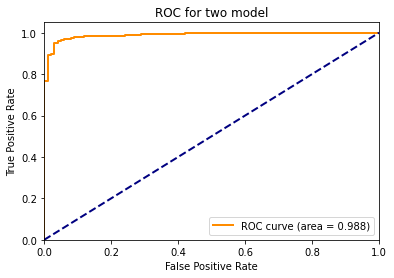

In [98]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y, pred_en)

roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for two model')
plt.legend(loc="lower right")
plt.show()

In [99]:
from sklearn.metrics import confusion_matrix

threshold = 0.35

pred_t = pred_en > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)

In [100]:
cm[0,0]/sum(cm[0,:]), cm[1,1]/sum(cm[1,:])

(0.91, 0.9744525547445255)

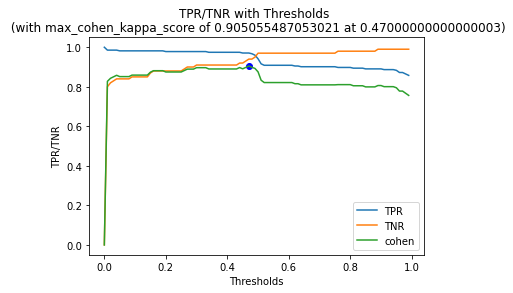

In [101]:
import numpy
from sklearn.metrics import cohen_kappa_score
mali = []
beni = []
cohen = []
tt = numpy.arange(0,1,0.01)
for thres in tt:
#     print(thres)
    pred_t = pred_en > thres
    pred_t.astype(int)
    cm = confusion_matrix(y,pred_t)
    mali.append(cm[1,1]/sum(cm[1,:]))
    beni.append(cm[0,0]/sum(cm[0,:]))
    cohen.append(cohen_kappa_score(y,pred_t))
# print(thresholds)
plt.figure(),plt.plot(tt,mali,label='TPR'),plt.plot(tt,beni,label='TNR'),plt.plot(tt,cohen,label='cohen')
plt.xlabel('Thresholds')
plt.ylabel('TPR/TNR')

plt.legend(loc="lower right")


net_max = cohen.index(max(cohen))
plt.title('TPR/TNR with Thresholds \n (with max_cohen_kappa_score of {} at {})'.format(max(cohen),tt[net_max]))
plt.scatter(tt[net_max], cohen[net_max], color='b')
plt.show()

In [91]:
import os
import matplotlib.pyplot as plt
import pandas as pd

In [92]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)



#     plt.figure(figsize=(4, 3))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

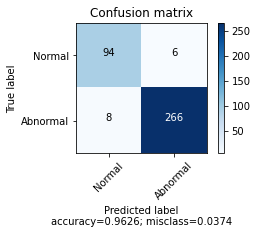

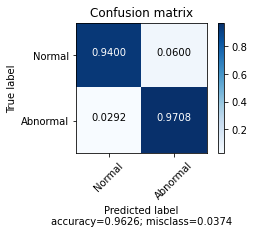

In [102]:
from sklearn.metrics import confusion_matrix

threshold = 0.47

pred_t = pred_en > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)

plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= False)
plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= True)

In [103]:
target_names = ('Normal','Abnormal')
pred_t = pred_en > 0.47
df = metrics.classification_report(y,pred_t,target_names=target_names,digits=4)
print(df)

              precision    recall  f1-score   support

      Normal     0.9216    0.9400    0.9307       100
    Abnormal     0.9779    0.9708    0.9744       274

    accuracy                         0.9626       374
   macro avg     0.9498    0.9554    0.9525       374
weighted avg     0.9629    0.9626    0.9627       374



## function:metric_report

In [25]:
import numpy
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score


def metric_report(y,pred,target_names=('Normal','Abnormal'),thresh = None, ret = True, prt = True):
    fpr, tpr, thresholds = metrics.roc_curve(y, pred_en)
    roc_auc = metrics.auc(fpr, tpr)
    
    
    mali = []
    beni = []
    cohen = []
    tt = numpy.arange(0,1,0.01)
    for thres in tt:
        pred_t = pred > thres
        pred_t.astype(int)
        cm = confusion_matrix(y,pred_t)
        mali.append(cm[1,1]/sum(cm[1,:]))
        beni.append(cm[0,0]/sum(cm[0,:]))
        cohen.append(cohen_kappa_score(y,pred_t))
    net_max = cohen.index(max(cohen))
    cohen_index = max(cohen)
    bst_thresh = tt[net_max]
    
    
#     target_names = ('Normal','Abnormal')
    if thresh:
        f_thresh = thresh
    else:            
        f_thresh = bst_thresh
        
    pred_t = pred > f_thresh
    df = metrics.classification_report(y,pred_t,target_names=target_names,digits=3)
    
    if prt:
        print('Auc is {:0.3f}, Cohen_kappa is {:0.3f}, Thresh = {}'.format(roc_auc,cohen_index,f_thresh))  
        print(df)
    
    if ret:
        return roc_auc,cohen_index,f_thresh,df
        

In [26]:
metric_report(y,pred_en)

Auc is 0.988, Cohen_kappa is 0.905, Thresh = 0.47000000000000003
              precision    recall  f1-score   support

      Normal      0.922     0.940     0.931       100
    Abnormal      0.978     0.971     0.974       274

    accuracy                          0.963       374
   macro avg      0.950     0.955     0.953       374
weighted avg      0.963     0.963     0.963       374



(0.9883941605839415,
 0.905055487053021,
 0.47000000000000003,
 '              precision    recall  f1-score   support\n\n      Normal      0.922     0.940     0.931       100\n    Abnormal      0.978     0.971     0.974       274\n\n    accuracy                          0.963       374\n   macro avg      0.950     0.955     0.953       374\nweighted avg      0.963     0.963     0.963       374\n')

In [27]:
metric_report(y,pred_en,thresh=0.5)

Auc is 0.988, Cohen_kappa is 0.905, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.858     0.970     0.911       100
    Abnormal      0.989     0.942     0.964       274

    accuracy                          0.949       374
   macro avg      0.923     0.956     0.938       374
weighted avg      0.954     0.949     0.950       374



(0.9883941605839415,
 0.905055487053021,
 0.5,
 '              precision    recall  f1-score   support\n\n      Normal      0.858     0.970     0.911       100\n    Abnormal      0.989     0.942     0.964       274\n\n    accuracy                          0.949       374\n   macro avg      0.923     0.956     0.938       374\nweighted avg      0.954     0.949     0.950       374\n')

## start ensemble bathc processing

In [28]:
import itertools

In [29]:
ensemble_ls_2 = itertools.combinations(pred_list,2)

In [42]:
for i,ls in enumerate(ensemble_ls_2):
    print(i)
    pred_en = np.array(ls).mean(axis = 0)
    metric_report(y,pred_en)

0
Auc is 0.985, Cohen_kappa is 0.887, Thresh = 0.47000000000000003
              precision    recall  f1-score   support

      Normal      0.888     0.950     0.918       100
    Abnormal      0.981     0.956     0.969       274

    accuracy                          0.955       374
   macro avg      0.935     0.953     0.943       374
weighted avg      0.956     0.955     0.955       374

1
Auc is 0.984, Cohen_kappa is 0.892, Thresh = 0.46
              precision    recall  f1-score   support

      Normal      0.904     0.940     0.922       100
    Abnormal      0.978     0.964     0.971       274

    accuracy                          0.957       374
   macro avg      0.941     0.952     0.946       374
weighted avg      0.958     0.957     0.957       374

2
Auc is 0.989, Cohen_kappa is 0.910, Thresh = 0.44
              precision    recall  f1-score   support

      Normal      0.948     0.920     0.934       100
    Abnormal      0.971     0.982     0.976       274

    accurac

In [30]:
key_set = model_dict.keys()

In [31]:
np.arange(2,7)

array([2, 3, 4, 5, 6])

In [32]:
dict_ensm = itertools.combinations(model_dict.keys(),2)

In [33]:
for keys in dict_ensm:
    print(keys)

('vit_base_patch16_224', 'tf_efficientnet_b5')
('vit_base_patch16_224', 'efficientnet_b3')
('vit_base_patch16_224', 'resnet34')
('vit_base_patch16_224', 'vit_deit_base_patch16_224')
('vit_base_patch16_224', 'swin_base_patch4_window7_224')
('tf_efficientnet_b5', 'efficientnet_b3')
('tf_efficientnet_b5', 'resnet34')
('tf_efficientnet_b5', 'vit_deit_base_patch16_224')
('tf_efficientnet_b5', 'swin_base_patch4_window7_224')
('efficientnet_b3', 'resnet34')
('efficientnet_b3', 'vit_deit_base_patch16_224')
('efficientnet_b3', 'swin_base_patch4_window7_224')
('resnet34', 'vit_deit_base_patch16_224')
('resnet34', 'swin_base_patch4_window7_224')
('vit_deit_base_patch16_224', 'swin_base_patch4_window7_224')


In [34]:
Eval_ensm_dict = {}
for comb_r in np.arange(1,len(key_set)+1):
    print(comb_r)
    dict_ensm = itertools.combinations(model_dict.keys(),comb_r)
    for i,keys in enumerate(dict_ensm):
        key = '+'.join(keys)
        print(key)
        Eval_ensm_dict[key]={}
        pred_ls = []
        for k in keys:
            pred = model_dict[k]['pred']
            pred_ls.append(pred)
        
        pred_en = np.vstack(pred_ls).mean(axis=0)
#         print(pred_en.shape)
        roc_auc,cohen_index,f_thresh,df = metric_report(y,pred_en,thresh=0.5)
        
        Eval_ensm_dict[key]['comb_num'] = comb_r
        Eval_ensm_dict[key]['auc'] = roc_auc
        Eval_ensm_dict[key]['kappa'] = cohen_index
        Eval_ensm_dict[key]['thresh'] = f_thresh
        Eval_ensm_dict[key]['report'] = df
        

1
vit_base_patch16_224
Auc is 0.980, Cohen_kappa is 0.878, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.908     0.890     0.899       100
    Abnormal      0.960     0.967     0.964       274

    accuracy                          0.947       374
   macro avg      0.934     0.929     0.931       374
weighted avg      0.946     0.947     0.946       374

tf_efficientnet_b5
Auc is 0.987, Cohen_kappa is 0.862, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.802     0.970     0.878       100
    Abnormal      0.988     0.912     0.949       274

    accuracy                          0.928       374
   macro avg      0.895     0.941     0.913       374
weighted avg      0.938     0.928     0.930       374

efficientnet_b3
Auc is 0.980, Cohen_kappa is 0.844, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.772     0.980     0.863       100
    Abnormal      0.992     0.89

Auc is 0.986, Cohen_kappa is 0.894, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.810     0.980     0.887       100
    Abnormal      0.992     0.916     0.953       274

    accuracy                          0.933       374
   macro avg      0.901     0.948     0.920       374
weighted avg      0.943     0.933     0.935       374

3
vit_base_patch16_224+tf_efficientnet_b5+efficientnet_b3
Auc is 0.991, Cohen_kappa is 0.918, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.826     0.950     0.884       100
    Abnormal      0.981     0.927     0.953       274

    accuracy                          0.933       374
   macro avg      0.903     0.939     0.918       374
weighted avg      0.939     0.933     0.935       374

vit_base_patch16_224+tf_efficientnet_b5+resnet34
Auc is 0.988, Cohen_kappa is 0.904, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.842     0.960    

Auc is 0.987, Cohen_kappa is 0.887, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.824     0.980     0.895       100
    Abnormal      0.992     0.923     0.957       274

    accuracy                          0.939       374
   macro avg      0.908     0.952     0.926       374
weighted avg      0.947     0.939     0.940       374

4
vit_base_patch16_224+tf_efficientnet_b5+efficientnet_b3+resnet34
Auc is 0.991, Cohen_kappa is 0.917, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.829     0.970     0.894       100
    Abnormal      0.988     0.927     0.957       274

    accuracy                          0.939       374
   macro avg      0.909     0.949     0.925       374
weighted avg      0.946     0.939     0.940       374

vit_base_patch16_224+tf_efficientnet_b5+efficientnet_b3+vit_deit_base_patch16_224
Auc is 0.992, Cohen_kappa is 0.918, Thresh = 0.5
              precision    recall  f1-score   supp

Auc is 0.987, Cohen_kappa is 0.900, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.845     0.980     0.907       100
    Abnormal      0.992     0.934     0.962       274

    accuracy                          0.947       374
   macro avg      0.919     0.957     0.935       374
weighted avg      0.953     0.947     0.948       374

vit_base_patch16_224+efficientnet_b3+resnet34+vit_deit_base_patch16_224+swin_base_patch4_window7_224
Auc is 0.992, Cohen_kappa is 0.906, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.829     0.970     0.894       100
    Abnormal      0.988     0.927     0.957       274

    accuracy                          0.939       374
   macro avg      0.909     0.949     0.925       374
weighted avg      0.946     0.939     0.940       374

tf_efficientnet_b5+efficientnet_b3+resnet34+vit_deit_base_patch16_224+swin_base_patch4_window7_224
Auc is 0.992, Cohen_kappa is 0.911, Thresh = 0.5

## results output

In [35]:
ensem_df = pd.DataFrame.from_dict(Eval_ensm_dict,orient='index')

In [36]:
ensem_df.head()

,comb_num,auc,kappa,thresh,report
vit_base_patch16_224,1,0.980328,0.877928,0.5,precision recall f1-score ...
tf_efficientnet_b5,1,0.987190,0.862360,0.5,precision recall f1-score ...
efficientnet_b3,1,0.979909,0.844123,0.5,precision recall f1-score ...
resnet34,1,0.981569,0.879450,0.5,precision recall f1-score ...
vit_deit_base_patch16_224,1,0.990365,0.876224,0.5,precision recall f1-score ...


In [37]:
ensem_df.to_csv('model_ensem_result_0.5.csv')

In [61]:
import json
with open('ensemble_results.json', 'w') as f:
        json.dump(Eval_ensm_dict, f) 

TypeError: Object of type int32 is not JSON serializable

In [110]:
from Own_util.Evaluation_metrics import *

In [111]:
ens_eval = Evaluation_metrics(y=y,pred=pred_en,title ='test',save_path='',dpi= 100, save_fig= False)

In [192]:
a = 0.7

In [26]:
a>0.5

True

In [28]:
1-(a>0.50)

0